Hi. In this notebook, we are going to be training different networks on the Fashion-MNIST dataset using PyTorch. Let's go!

### Basic imports

In [ ]:
## Standard libraries
import os
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Progress bar
from tqdm.notebook import tqdm

Let us now import PyTorch and print its version installed in Colab.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
print("Using torch", torch.__version__)

Using torch 2.0.1+cu118


We define a function to set a seed on all libraries we might interact with in this notebook (`numpy` and `torch`). This allows us to make our training reproducible.

In [ ]:
# Path to the folder where the datasets are downloaded
DATASET_PATH = "/data"
# Path to the folder where models are saved
CHECKPOINT_PATH = "/saved_models"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


We create some functions to load and save the model.

In [ ]:
def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, model):
    """
    Loads a saved model from disk.
    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        model - Model into which the state dict is loaded
    """
    model_file = _get_model_file(model_path, model_name)
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    model.load_state_dict(torch.load(model_file, map_location=device))
    return model

def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.
    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    os.makedirs(model_path, exist_ok=True)
    model_file = _get_model_file(model_path, model_name)
    torch.save(model.state_dict(), model_file)

### Downloading Fashion-MNIST

In [ ]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image =>
# first make them a tensor, then normalize them in the range -1 to 1
resize = (28, 28)
transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True,
                             transform=transform, download=True)
train_set, val_set = data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False,
                        transform=transform, download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11785883.02it/s]


Extracting /data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 171925.88it/s]


Extracting /data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3267380.25it/s]


Extracting /data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4900652.97it/s]

Extracting /data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



In [ ]:
# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True,
                               drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False,
                             drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False,
                              drop_last=False)

for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Let us now visualize some of the images:

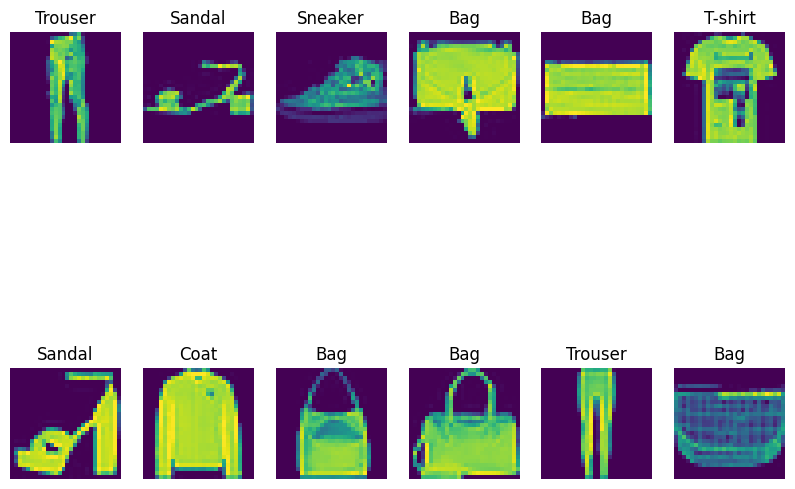

In [ ]:
classNames = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def imshow(img, plot):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()   # convert from tensor
    plot.imshow(np.transpose(npimg, (1, 2, 0)))

# show some training images
plt.figure(figsize=(10, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(12):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(2, 6, i + 1)
    imshow(image, plt)
    plt.axis('off')
    plt.title(classNames[label])

### Task 1: Training a fully connected neural network

We train a fully connected neural network (MLP) to see whether it can sufficiently capture all information contained in the Fashion-MNIST dataset.

#### Creating the model

In [ ]:
class MLP(nn.Module):
  """A fully connected neural network."""
  def __init__(self, num_classes=10):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(28*28, 50),
        nn.Sigmoid(),
        nn.Linear(50, 30),
        nn.Sigmoid(),
        nn.Linear(30, 30),
        nn.Sigmoid(),
        nn.Linear(30, num_classes)
    )

  def forward(self, x):
    x = x.view(-1, 28*28)  # Reshape images to a flat vector
    return self.network(x)

In [ ]:
model_mlp = MLP()
print(model_mlp)

MLP(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=30, out_features=10, bias=True)
  )
)


Let us define a function to initialize the weights. By default, PyTorch uses He initializations for linear layers optimized for ReLU activations.

In [ ]:
# Note that no_grad() is used here to avoid tracking this computation in the autograd graph.
@torch.no_grad()
def init_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight)
  elif isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

# Apply the function recursively on the module and its submodules.
model_mlp.apply(init_weights)

MLP(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=30, out_features=10, bias=True)
  )
)

#### Training the model

In [ ]:
def train_model(model, model_name, optimizer, loss_module, scramble = False,
                plot=True, patience=3, num_epochs=15):
    """
    Train a model on the training data set.
    Inputs:
        model - Our network
        model_name - (str) Name of the model, used for creating checkpoints
        scramble - Should the pixels be permuted?
        patience - If perf. on valid. set hasn't improved for `patience` epochs, we stop training early
        num_epochs - Number of epochs we want to (maximally) train for
        plot - Should the train and validation accuracies be plotted?
    """
    train_scores = []
    val_scores = []
    best_val_epoch = -1

    for epoch in range(num_epochs):
        ############
        # Training #
        ############
        model.train()
        true_preds, count = 0., 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            ## Step 1: Move input data to device
            imgs, labels = imgs.to(device), labels.to(device)

            ## Step 1b: To scramble
            if scramble:
              imgs = imgs.view(-1, 28*28)
              imgs = imgs[:, perm]
              imgs = imgs.view(-1, 1, 28, 28)

            ## Step 2: Run the model on the input data
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
            preds = model(imgs)

            ## Step 3: Calculate the loss
            loss = loss_module(preds, labels)

            ## Step 4: Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()
            # Record statistics during training
            true_preds += (preds.argmax(dim=-1) == labels).sum()
            count += labels.shape[0]
        train_acc = true_preds / count
        train_scores.append(train_acc.item())

        ##############
        # Validation #
        ##############
        val_acc = test_model(model, val_loader)
        val_scores.append(val_acc)
        print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

        if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
            print("\t   (New best performance...)")
            save_model(model, CHECKPOINT_PATH, model_name)
            best_val_epoch = epoch
        elif best_val_epoch <= epoch - patience:
            print(f"Early stopping due to no improvement over the last {patience} epochs")
            break

    if plot:
      # Plot a curve of the training and validation accuracy
      plt.plot([i for i in range(1, len(train_scores) + 1)], train_scores,
              label = 'Training acc.')
      plt.plot([i for i in range(1, len(val_scores) + 1)], val_scores,
              label = 'Validation acc.')
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.title("Performance of the model")
      plt.legend()
      plt.show()
      plt.close()

    # Output test acc. on the best model (based on validation acc.)
    load_model(CHECKPOINT_PATH, model_name, model)
    test_acc = test_model(model, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")

In [ ]:
# Use a permutation to scramble the images
perm = torch.randperm(784)

def test_model(model, data_loader, scramble=False):
    """
    Test a model on a specified dataset.
    Inputs:
        model - Trained model
        data_loader - DataLoader object of the dataset to test on (validation or test)
        scramble - Should the pixels be permuted?
    """
    model.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        if scramble:
          imgs = imgs.view(-1, 28*28)
          imgs = imgs[:, perm]
          imgs = imgs.view(-1, 1, 28, 28)

        with torch.no_grad():
            preds = model(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

We now train our model.

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 36.72%, Validation accuracy: 63.00%
	   (New best performance...)


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 66.70%, Validation accuracy: 71.68%
	   (New best performance...)


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 75.41%, Validation accuracy: 76.36%
	   (New best performance...)


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 78.84%, Validation accuracy: 79.49%
	   (New best performance...)


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 81.45%, Validation accuracy: 80.20%
	   (New best performance...)


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 83.44%, Validation accuracy: 83.60%
	   (New best performance...)


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 84.68%, Validation accuracy: 84.26%
	   (New best performance...)


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 85.38%, Validation accuracy: 84.41%
	   (New best performance...)


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 86.13%, Validation accuracy: 84.87%
	   (New best performance...)


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 86.62%, Validation accuracy: 86.17%
	   (New best performance...)


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 87.08%, Validation accuracy: 86.02%


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 87.56%, Validation accuracy: 86.44%
	   (New best performance...)


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 88.03%, Validation accuracy: 85.72%


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 88.07%, Validation accuracy: 87.23%
	   (New best performance...)


Epoch 15:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 88.59%, Validation accuracy: 87.36%
	   (New best performance...)


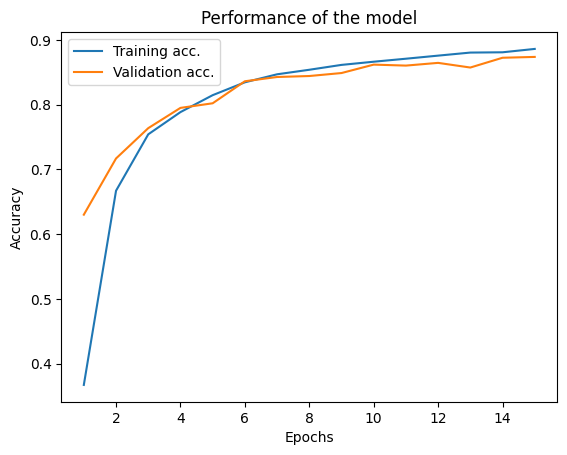

============= Test accuracy: 86.45% ==============



In [ ]:
optimizer = optim.SGD(model_mlp.parameters(), lr=1e-2, momentum=0.9)
loss_module = nn.CrossEntropyLoss()

model_mlp.to(device)
train_model(model_mlp, 'mlp', optimizer, loss_module)

### Task 2: Training LeNet-5

We train a LeNet-5 incorporating the following changes from the original model design:

(1) we use the ReLU activation function;  
(2) we use max-pooling instead of average pooling; and   
(3) we incorporate dropout to prevent overfitting.

#### Creating the model

In [ ]:
class LeNet(nn.Module):
  """A modified LeNet-5 model."""
  def __init__(self, num_classes=10):
    super().__init__()
    self.network = nn.Sequential(
        # Layer 1
        nn.Conv2d(1, 6, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.1),  # 10% prob. of element being zero-ed
        # Layer 2
        nn.LazyConv2d(16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.2),
        # Layer 3
        nn.Flatten(),
        nn.LazyLinear(120),
        nn.ReLU(),
        nn.Dropout(p=0.25),
        # Layer 4
        nn.LazyLinear(84),
        nn.ReLU(),
        nn.Dropout(p=0.35),
        # Layer 5
        nn.LazyLinear(num_classes)
    )

  def forward(self, x):
    return self.network(x)

  def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.network:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [ ]:
model_cnn = LeNet()
# To check if outputs are of the expected size
model_cnn.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Dropout2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Dropout2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Dropout output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Dropout output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
# Initialize weights
model_cnn.apply(init_weights)

LeNet(
  (network): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=400, out_features=120, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=120, out_features=84, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.35, inplace=False)
    (15): Linear(in_features=84, out_features=10, bias=True)
  )
)

#### Training the model

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 68.80%, Validation accuracy: 81.50%
	   (New best performance...)


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 80.79%, Validation accuracy: 84.45%
	   (New best performance...)


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 83.18%, Validation accuracy: 85.68%
	   (New best performance...)


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 84.57%, Validation accuracy: 87.33%
	   (New best performance...)


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 85.18%, Validation accuracy: 87.84%
	   (New best performance...)


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 85.78%, Validation accuracy: 88.00%
	   (New best performance...)


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 86.36%, Validation accuracy: 87.96%


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 86.58%, Validation accuracy: 88.59%
	   (New best performance...)


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 86.88%, Validation accuracy: 88.11%


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 87.27%, Validation accuracy: 88.74%
	   (New best performance...)


Epoch 11:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 87.53%, Validation accuracy: 89.36%
	   (New best performance...)


Epoch 12:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 87.57%, Validation accuracy: 88.68%


Epoch 13:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 87.70%, Validation accuracy: 88.04%


Epoch 14:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 87.75%, Validation accuracy: 89.11%
Early stopping due to no improvement over the last 3 epochs


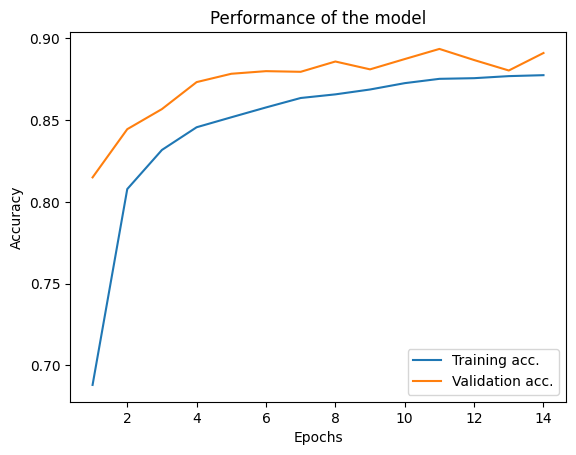

============= Test accuracy: 88.66% ==============



In [ ]:
optimizer = optim.SGD(model_cnn.parameters(), lr=1e-2, momentum=0.9)
loss_module = nn.CrossEntropyLoss()

model_cnn.to(device)
train_model(model_cnn, 'cnn', optimizer, loss_module)

### Task 3: Scrambling the pixels

We scramble the pixels in our input images to check if the network actually uses positional information to make a decision.

The scrambling code is already incorporated in our `train` and `test` functions. We just need to do `scramble=True` to check the results.

#### For the fully connected neural network

In [ ]:
model_mlp_new = MLP()
model_mlp_new.apply(init_weights)

optimizer = optim.SGD(model_mlp_new.parameters(), lr=1e-2, momentum=0.9)
loss_module = nn.CrossEntropyLoss()

model_mlp_new.to(device)
train_model(model_mlp_new, 'mlp_scrambled', optimizer, loss_module, scramble=True, plot=False)

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 34.66%, Validation accuracy: 16.38%
	   (New best performance...)


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 63.35%, Validation accuracy: 13.10%


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 71.79%, Validation accuracy: 12.97%


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 76.18%, Validation accuracy: 15.23%
Early stopping due to no improvement over the last 3 epochs
============= Test accuracy: 16.63% ==============



#### For LeNet-5

In [ ]:
model_cnn_new = LeNet()
# Do a dry run to initialize the lazy layers
model_cnn_new.layer_summary((1, 1, 28, 28))
model_cnn_new.apply(init_weights)

optimizer = optim.SGD(model_cnn_new.parameters(), lr=1e-2, momentum=0.9)
loss_module = nn.CrossEntropyLoss()

model_cnn_new.to(device)
train_model(model_cnn_new, 'cnn_scrambled', optimizer, loss_module, scramble=True, plot=False)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Dropout2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Dropout2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Dropout output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Dropout output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 65.50%, Validation accuracy: 17.21%
	   (New best performance...)


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 78.22%, Validation accuracy: 17.68%
	   (New best performance...)


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 80.40%, Validation accuracy: 19.30%
	   (New best performance...)


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 81.76%, Validation accuracy: 17.79%


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 82.57%, Validation accuracy: 19.00%


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 82.68%, Validation accuracy: 17.98%
Early stopping due to no improvement over the last 3 epochs
============= Test accuracy: 18.82% ==============



### Task 4: FGSM adversarial attack

In this task, we explore one of the earliest adversarial attacks on neural networks called the [Fast Gradient Sign Method](https://arxiv.org/abs/1412.6572) attack.

In short, the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.

$$\boldsymbol{x} \leftarrow \boldsymbol{x} + \epsilon \times \text{sign}(\nabla_{\boldsymbol{x}}J(\boldsymbol{\theta}, \boldsymbol{x}, y))$$

#### Required code

We use a new test `DataLoader` with batch-size of 1 so that we can test each example.

In [ ]:
fgsm_test_loader = data.DataLoader(test_set, batch_size=1, shuffle=True,
                                   drop_last=False)

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

# FGSM attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0, 1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Restores the tensors to their original scale
def denorm(batch, mean=[0.5], std=[0.5]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [ ]:
def fgsm_test(model, loss_module, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []

    for imgs, labels in fgsm_test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        # Set requires_grad attribute of tensor: important for Attack
        imgs.requires_grad = True

        output = model(imgs)  # Forward pass
        init_pred = output.max(1, keepdim=True)[1]

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != labels.item():
            continue

        loss = loss_module(output, labels)  # Calculate the loss
        model.zero_grad()  # Zero all existing gradients
        loss.backward()  # Calculate gradients in backward pass

        data_grad = imgs.grad.data  # Collect the gradients
        data_denorm = denorm(imgs)  # Restore data to original scale

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize(
            (0.5,), (0.5,)
            )(perturbed_data)
        perturbed_data_normalized.to(device)

        output = model(perturbed_data_normalized)  # Re-classify perturbed image
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == labels.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(fgsm_test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(fgsm_test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

#### For the fully connected neural network

In [ ]:
# Set the MLP model in evaluation mode.
model_mlp.eval()

mlp_accuracies = []
mlp_adv_examples = []

# Run test for each epsilon
for eps in epsilons:
    mlp_acc, mlp_ex = fgsm_test(model_mlp, loss_module, eps)
    mlp_accuracies.append(mlp_acc)
    mlp_adv_examples.append(mlp_ex)

Epsilon: 0	Test Accuracy = 8645 / 10000 = 0.8645
Epsilon: 0.05	Test Accuracy = 3433 / 10000 = 0.3433
Epsilon: 0.1	Test Accuracy = 1066 / 10000 = 0.1066
Epsilon: 0.15	Test Accuracy = 360 / 10000 = 0.036
Epsilon: 0.2	Test Accuracy = 136 / 10000 = 0.0136
Epsilon: 0.25	Test Accuracy = 59 / 10000 = 0.0059
Epsilon: 0.3	Test Accuracy = 26 / 10000 = 0.0026


#### For LeNet-5

In [ ]:
# Set the LeNet model in evaluation mode.
model_cnn.eval()

cnn_accuracies = []
cnn_adv_examples = []

# Run test for each epsilon
for eps in epsilons:
    cnn_acc, cnn_ex = fgsm_test(model_cnn, loss_module, eps)
    cnn_accuracies.append(cnn_acc)
    cnn_adv_examples.append(cnn_ex)

Epsilon: 0	Test Accuracy = 8866 / 10000 = 0.8866
Epsilon: 0.05	Test Accuracy = 4491 / 10000 = 0.4491
Epsilon: 0.1	Test Accuracy = 1933 / 10000 = 0.1933
Epsilon: 0.15	Test Accuracy = 1161 / 10000 = 0.1161
Epsilon: 0.2	Test Accuracy = 1005 / 10000 = 0.1005
Epsilon: 0.25	Test Accuracy = 948 / 10000 = 0.0948
Epsilon: 0.3	Test Accuracy = 921 / 10000 = 0.0921


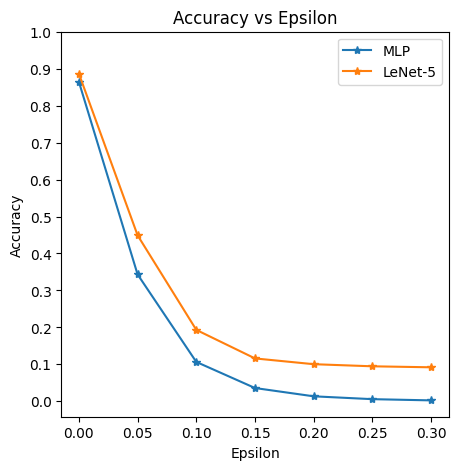

In [ ]:
# Plot accuracy vs epsilon
plt.figure(figsize=(5,5))
plt.plot(epsilons, mlp_accuracies, "*-", label='MLP')
plt.plot(epsilons, cnn_accuracies, "*-", label='LeNet-5')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We can observe that the performance of the CNN is better than the MLP with all values of $\epsilon$ that we considered.

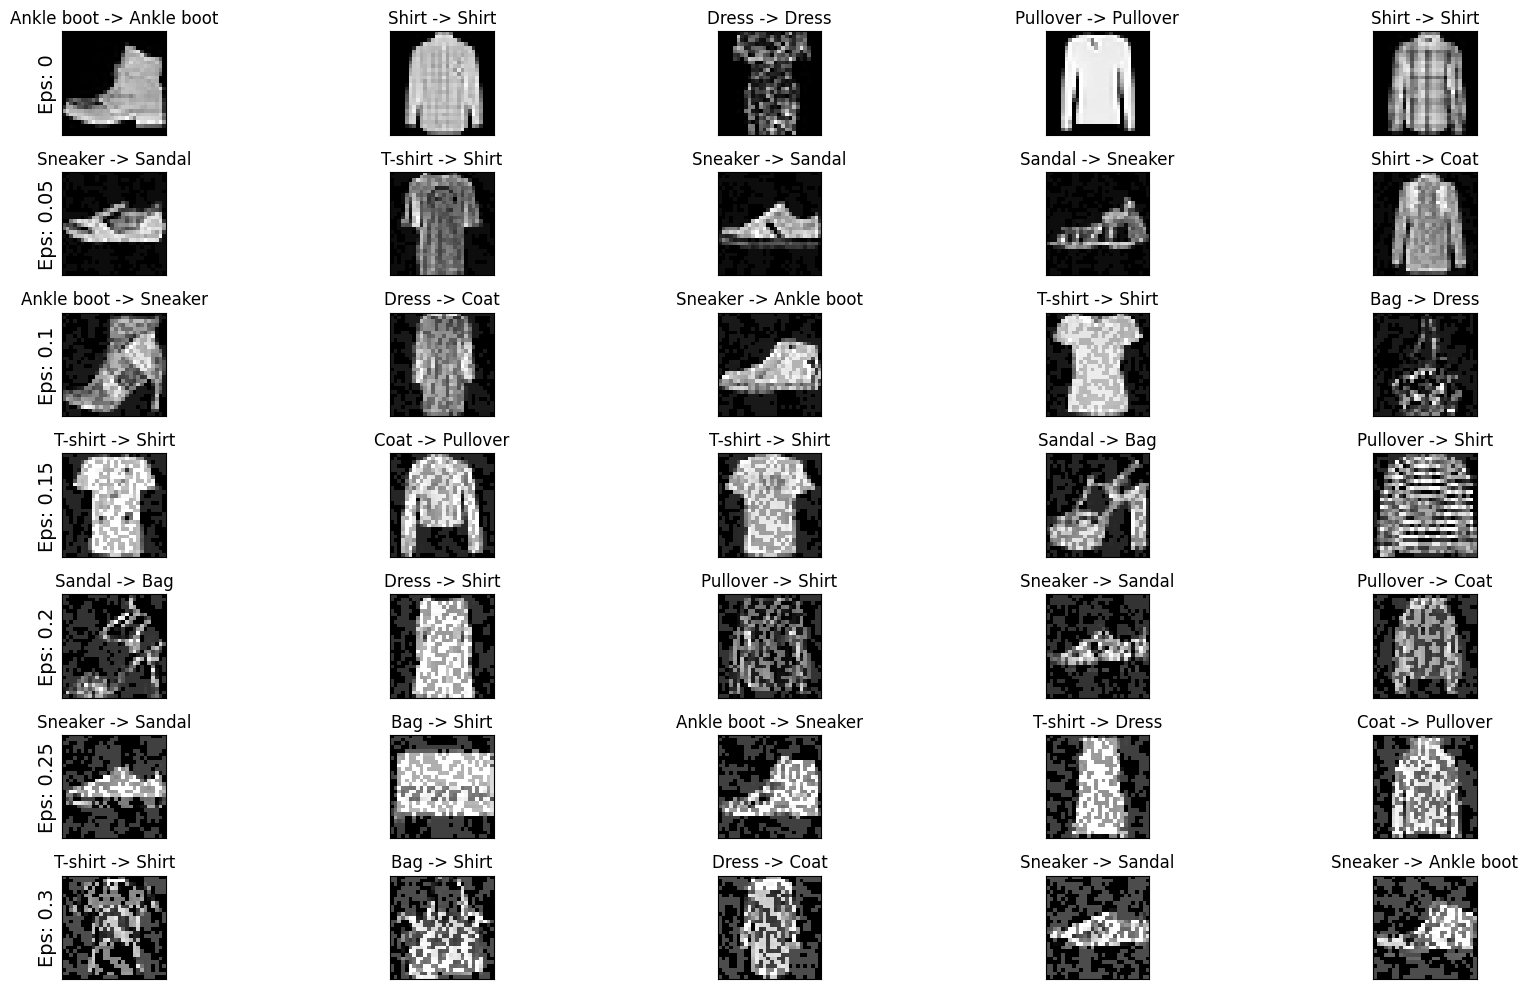

In [ ]:
# Plot examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(18,10))
for i in range(len(epsilons)):
    for j in range(len(cnn_adv_examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(cnn_adv_examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig, adv, ex = cnn_adv_examples[i][j]
        plt.title(f"{classNames[orig]} -> {classNames[adv]}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### Conclusion

We recap the (test) accuracies of the models we trained in the following table:

| Architecture                 | Test accuracy |
|------------------------------|---------------|
| MLP                          | 86.45%        |
| MLP after scrambling         | 16.63%        |
| CNN                          | 88.66%        |
| CNN after scrambling         | 18.82%        |

We make some observations:
1. The performance of the CNN beats the MLP by more than 2%.
2. Scrambling the images worsens the performance of both networks considerably.

Even a good old MLP is strong enough for FashionMNIST, which one could think would be sufficiently harder and diverse than MNIST!